In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/road-accident-united-kingdom-uk-dataset/UK_Accident.csv


In [2]:
!pip install -q scikit-learn imbalanced-learn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 88.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
# Step 1: Import Libraries
# ------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt


# Version check
import sklearn, imblearn
print("✅ scikit-learn version:", sklearn.__version__)
print("✅ imbalanced-learn version:", imblearn.__version__)


✅ scikit-learn version: 1.6.1
✅ imbalanced-learn version: 0.13.0


# Load Dataset

In [4]:
file_path = "/kaggle/input/road-accident-united-kingdom-uk-dataset/UK_Accident.csv"
df = pd.read_csv(file_path)
df.head

<bound method NDFrame.head of          Unnamed: 0 Accident_Index  Location_Easting_OSGR  \
0                 0  200501BS00001               525680.0   
1                 1  200501BS00002               524170.0   
2                 2  200501BS00003               524520.0   
3                 3  200501BS00004               526900.0   
4                 4  200501BS00005               528060.0   
...             ...            ...                    ...   
1504145      464692       2.01E+12               310037.0   
1504146      464693       2.01E+12               321509.0   
1504147      464694       2.01E+12               321337.0   
1504148      464695       2.01E+12               323869.0   
1504149      464696       2.01E+12               314072.0   

         Location_Northing_OSGR  Longitude   Latitude  Police_Force  \
0                      178240.0  -0.191170  51.489096             1   
1                      181650.0  -0.211708  51.520075             1   
2                      1

In [5]:
#  Basic Data Cleaning
# ------------------------------
# Drop duplicates
df.drop_duplicates(inplace=True)

In [6]:
print("Null values per column:\n", df.isnull().sum())

Null values per column:
 Unnamed: 0                                           0
Accident_Index                                       0
Location_Easting_OSGR                              101
Location_Northing_OSGR                               0
Longitude                                          101
Latitude                                             0
Police_Force                                         0
Accident_Severity                                    0
Number_of_Vehicles                                   0
Number_of_Casualties                                 0
Date                                                 0
Day_of_Week                                          0
Time                                               117
Local_Authority_(District)                           0
Local_Authority_(Highway)                            0
1st_Road_Class                                       0
1st_Road_Number                                      0
Road_Type                               

In [7]:
# Fill missing values with mode for categorical & median for numeric
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

/tmp/ipykernel_13/2742319241.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_13/2742319241.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [8]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)


In [9]:
#Categorical Columns: Mode Imputation
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

In [10]:
print("Null values per column:\n", df.isnull().sum())

Null values per column:
 Unnamed: 0                                     0
Accident_Index                                 0
Location_Easting_OSGR                          0
Location_Northing_OSGR                         0
Longitude                                      0
Latitude                                       0
Police_Force                                   0
Accident_Severity                              0
Number_of_Vehicles                             0
Number_of_Casualties                           0
Date                                           0
Day_of_Week                                    0
Time                                           0
Local_Authority_(District)                     0
Local_Authority_(Highway)                      0
1st_Road_Class                                 0
1st_Road_Number                                0
Road_Type                                      0
Speed_limit                                    0
Junction_Control                            

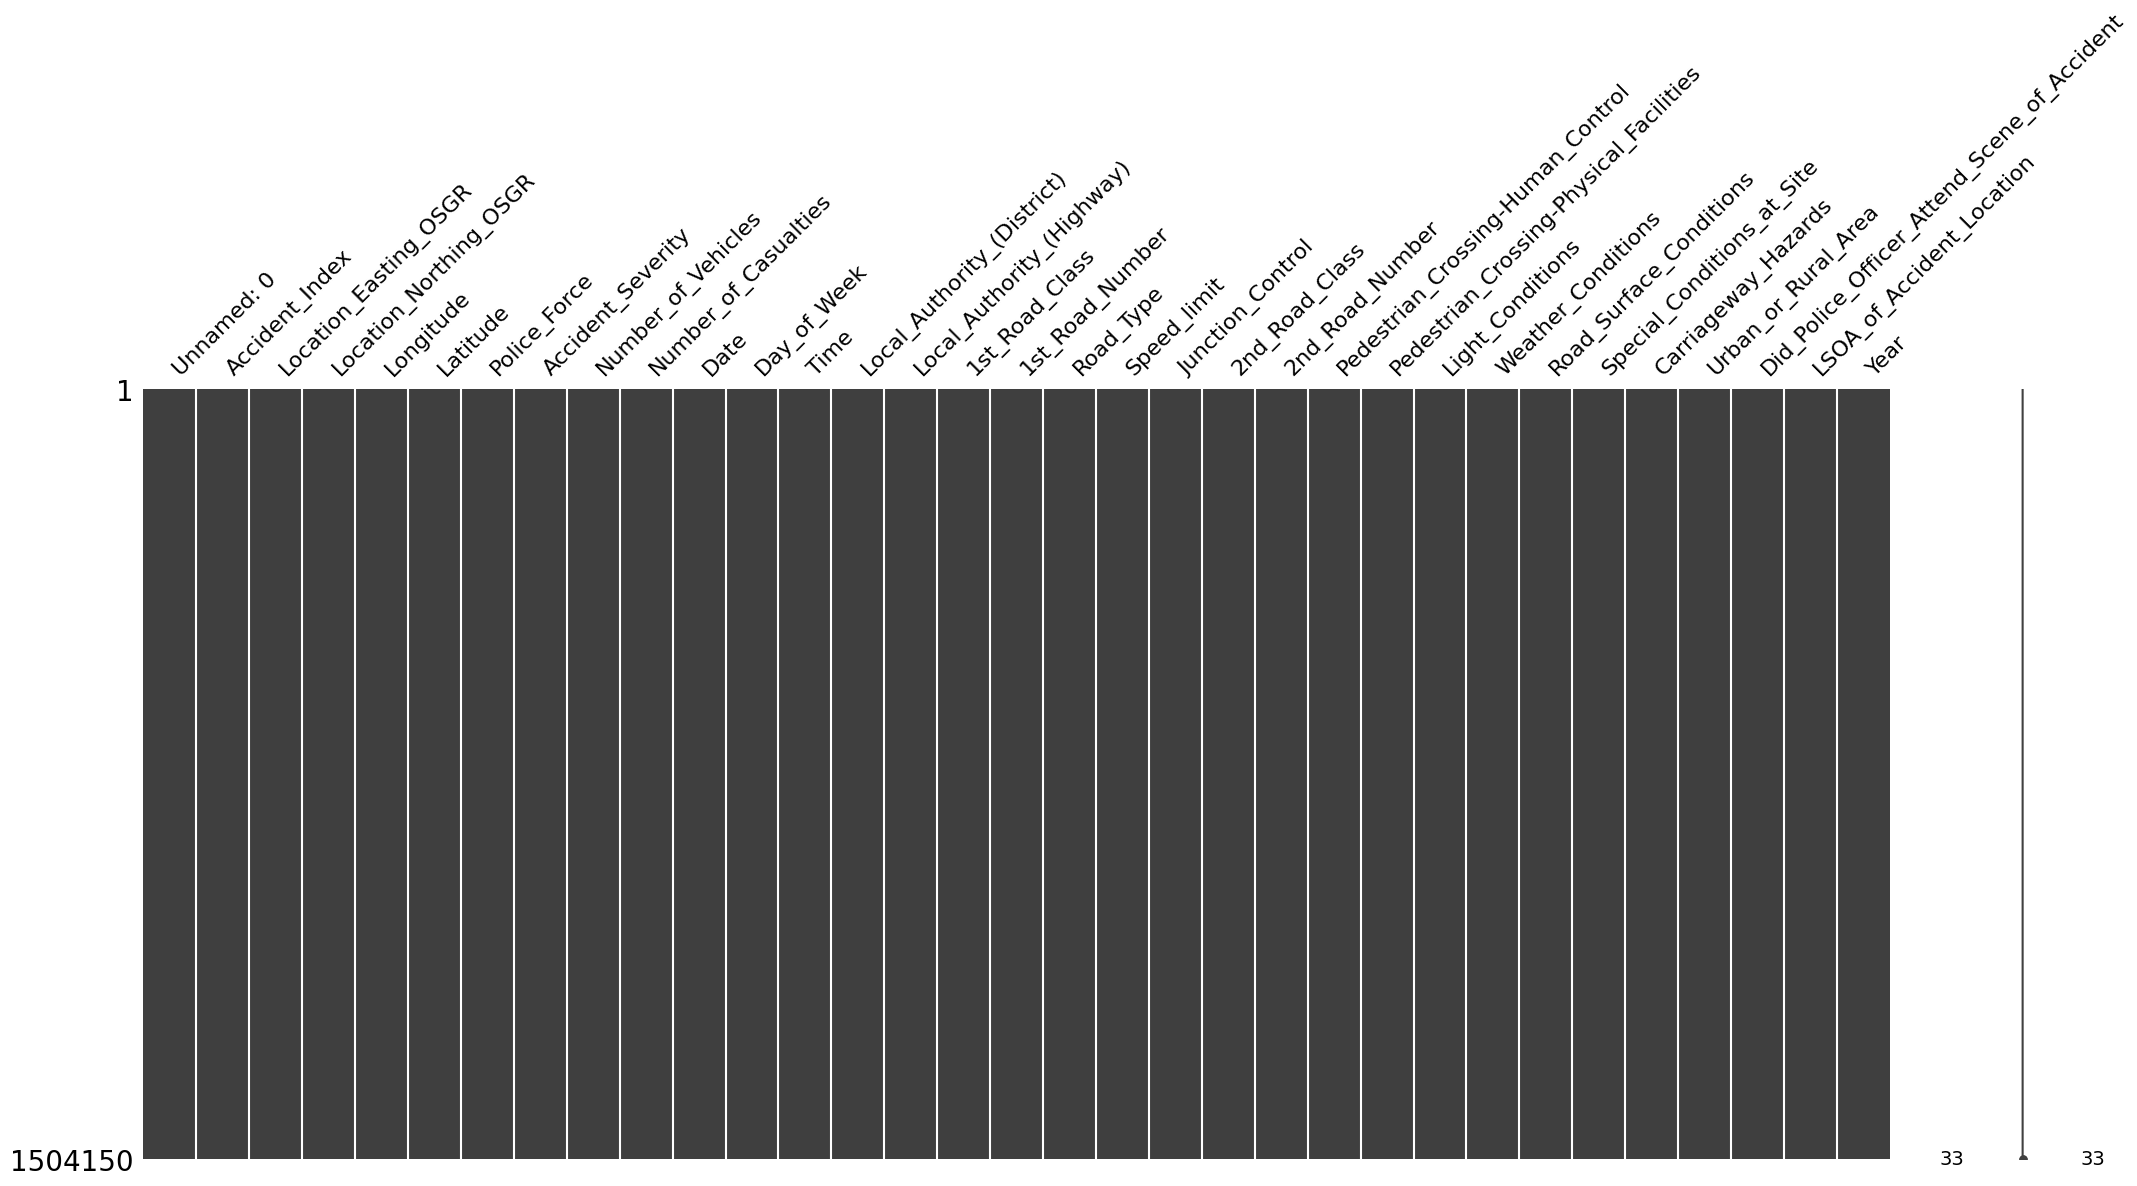

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


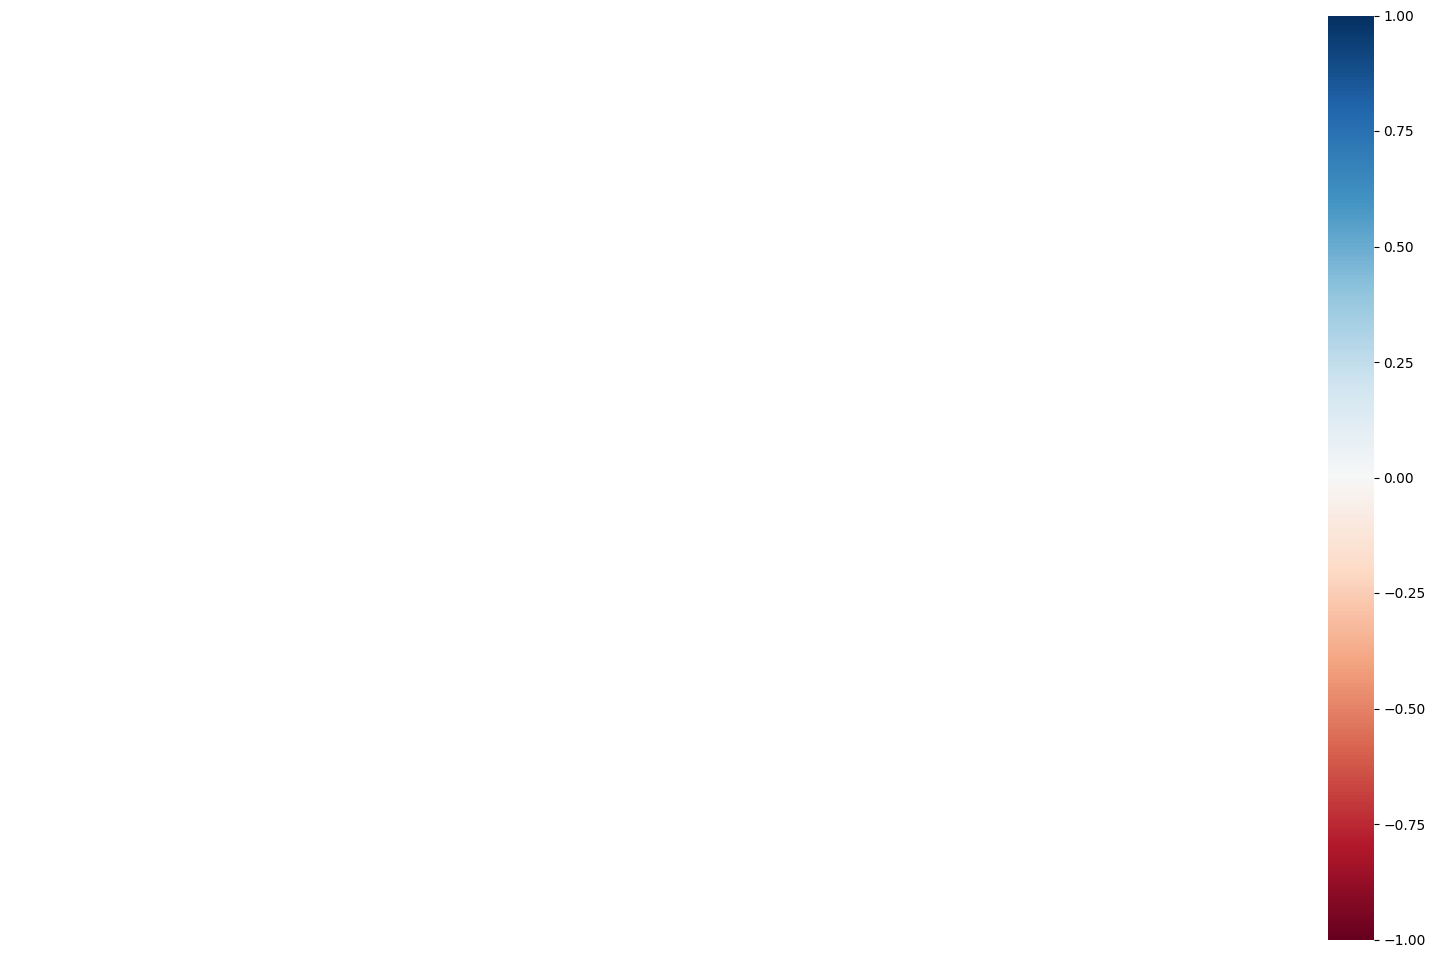

In [11]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(df)
plt.show()
msno.heatmap(df)
plt.show()

In [12]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Print categorical columns
print("Categorical Columns:")
print(categorical_cols)


Categorical Columns:
Index(['Accident_Index', 'Date', 'Time', 'Local_Authority_(Highway)',
       'Road_Type', 'Junction_Control', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location'],
      dtype='object')


In [13]:
from sklearn.preprocessing import LabelEncoder
# Apply label encoding to each categorical column
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

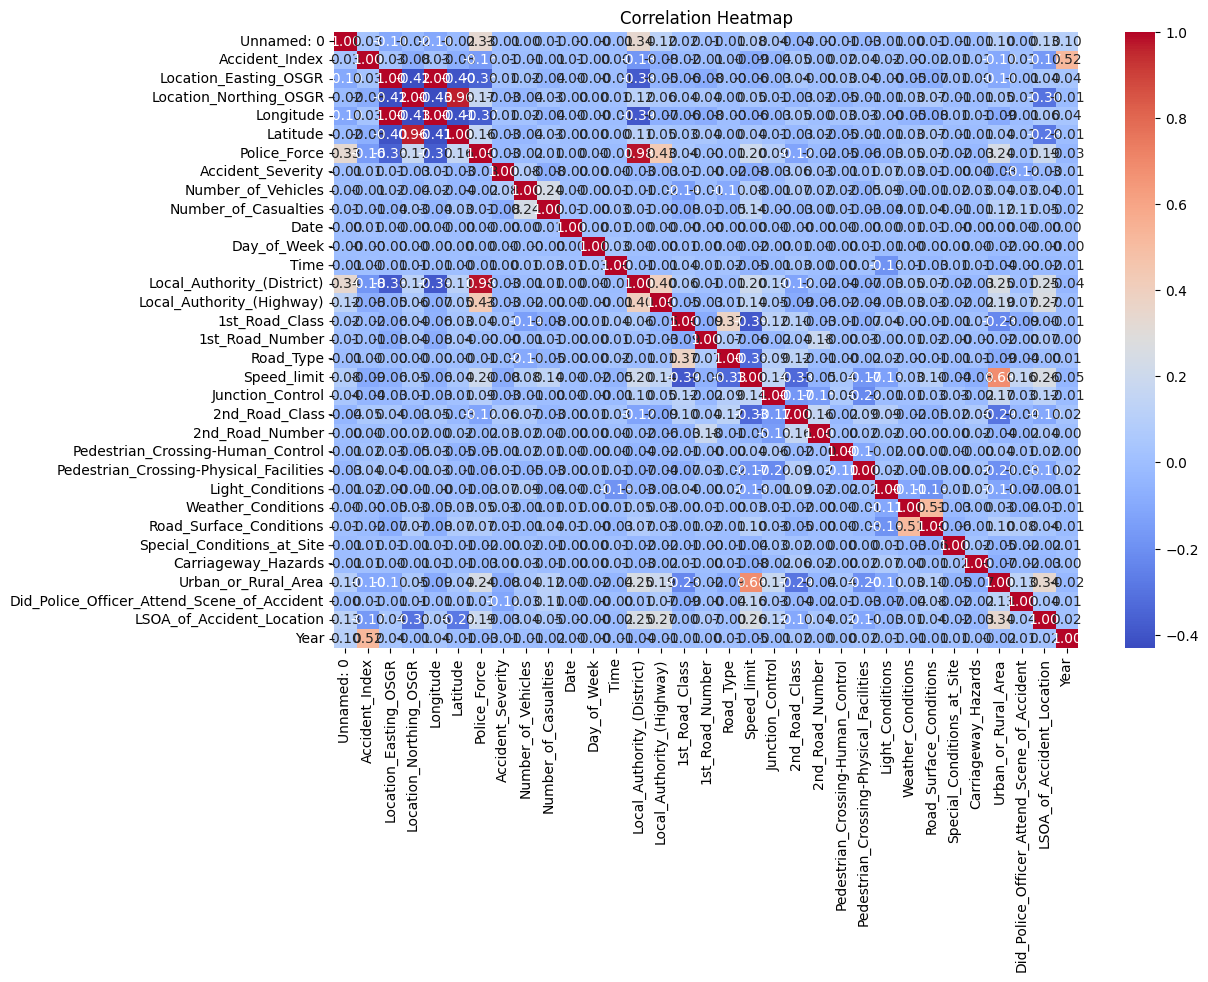

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation Heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [15]:
class_count = df["Accident_Severity"].value_counts()
class_count

Accident_Severity
3    1280205
2     204504
1      19441
Name: count, dtype: int64

In [16]:
# Relabel values
df['Accident_Severity'] = df['Accident_Severity'].replace({
    3: 2,
    2: 1,
    1: 0
})

# Check the new distribution
print(df['Accident_Severity'].value_counts())


Accident_Severity
2    1280205
1     204504
0      19441
Name: count, dtype: int64


In [17]:
df.head()

,Unnamed: 0,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,...,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Year
0,0,372,525680.0,178240.0,-0.191170,51.489096,1,1,1,1,...,4,4,5,5,6,3,1,1,2839,2005
1,1,373,524170.0,181650.0,-0.211708,51.520075,1,2,1,1,...,3,2,1,0,6,3,1,1,2899,2005
2,2,374,524520.0,182240.0,-0.206458,51.525301,1,2,2,1,...,2,2,1,0,6,3,1,1,2847,2005
3,3,375,526900.0,177530.0,-0.173862,51.482442,1,2,1,1,...,2,4,1,0,6,3,1,1,2830,2005
4,4,376,528060.0,179040.0,-0.156618,51.495752,1,2,1,1,...,2,1,1,5,6,3,1,1,2853,2005


In [18]:
# Feature & Target
# ------------------------------
target_col = "Accident_Severity"  # replace with actual target column if different
X = df.drop(target_col, axis=1)
y = df[target_col]

In [19]:
# Standardize features for KNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Step 5: Define Models
# ------------------------------
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "XGB Classifier": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "CatBoost Classifier": CatBoostClassifier(verbose=0, random_state=42),
    "LightGBM Classifier": LGBMClassifier(random_state=42)
}

In [21]:
# Step 6: Train & Evaluate Models
# ------------------------------
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return acc, prec, rec, f1, report, cm


In [22]:
# Step 6a: Split Imbalanced Data
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

results_imbalanced = {}
for name, model in models.items():
    acc, prec, rec, f1, report, cm = evaluate_model(model, X_train, X_test, y_train, y_test)
    results_imbalanced[name] = {
        "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "Report": report, "Confusion_Matrix": cm
    }

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.161612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3451
[LightGBM] [Info] Number of data points in the train set: 1203320, number of used features: 32
[LightGBM] [Info] Start training from score -4.348586
[LightGBM] [Info] Start training from score -1.995397
[LightGBM] [Info] Start training from score -0.161208


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [23]:
# Step 6b: Balance Data using SMOTE
# ------------------------------
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_scaled, y)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)

results_balanced = {}
for name, model in models.items():
    acc, prec, rec, f1, report, cm = evaluate_model(model, X_train_bal, X_test_bal, y_train_bal, y_test_bal)
    results_balanced[name] = {
        "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "Report": report, "Confusion_Matrix": cm
    }

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.321956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7288
[LightGBM] [Info] Number of data points in the train set: 3072492, number of used features: 32
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Imbalanced Data ===

Model: Random Forest
Accuracy: 0.8566, Precision: 0.8413, Recall: 0.8566, F1: 0.7999
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.03      0.06      3888
           1       0.73      0.06      0.10     40901
           2       0.86      1.00      0.92    256041

    accuracy                           0.86    300830
   macro avg       0.83      0.36      0.36    300830
weighted avg       0.84      0.86      0.80    300830



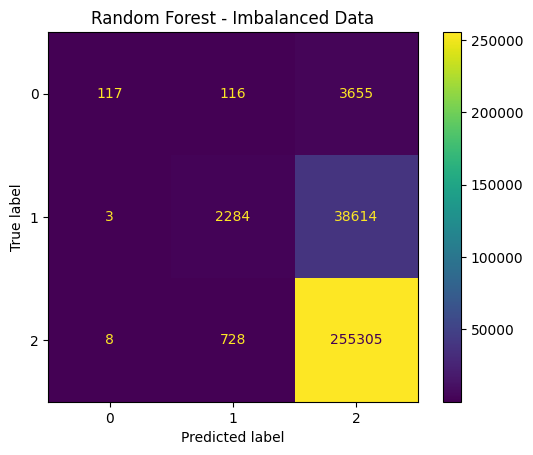


Model: Gradient Boosting
Accuracy: 0.8516, Precision: 0.8213, Recall: 0.8516, F1: 0.7844
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.00      0.00      3888
           1       0.68      0.01      0.01     40901
           2       0.85      1.00      0.92    256041

    accuracy                           0.85    300830
   macro avg       0.62      0.34      0.31    300830
weighted avg       0.82      0.85      0.78    300830



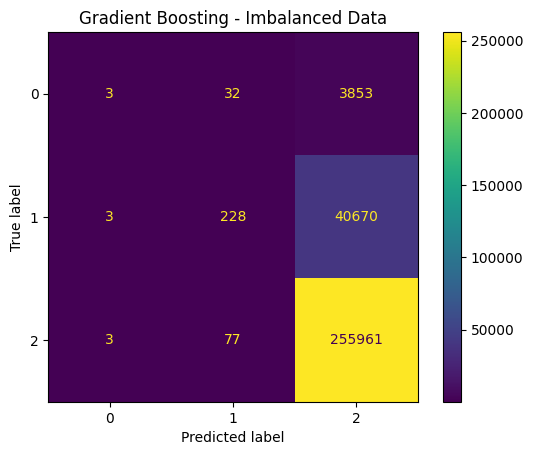


Model: K-Nearest Neighbors
Accuracy: 0.8307, Precision: 0.7649, Recall: 0.8307, F1: 0.7885
Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.02      0.03      3888
           1       0.25      0.08      0.12     40901
           2       0.86      0.96      0.91    256041

    accuracy                           0.83    300830
   macro avg       0.40      0.35      0.35    300830
weighted avg       0.76      0.83      0.79    300830



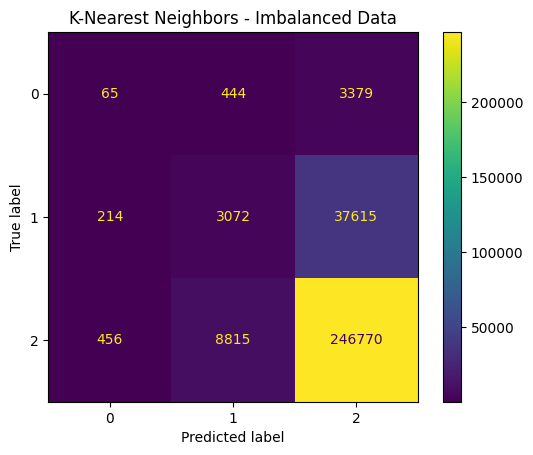


Model: XGB Classifier
Accuracy: 0.8531, Precision: 0.8165, Recall: 0.8531, F1: 0.7905
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.01      0.03      3888
           1       0.61      0.02      0.05     40901
           2       0.85      1.00      0.92    256041

    accuracy                           0.85    300830
   macro avg       0.66      0.35      0.33    300830
weighted avg       0.82      0.85      0.79    300830



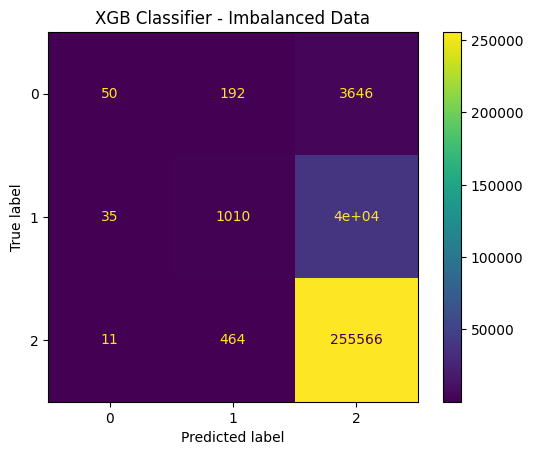


Model: CatBoost Classifier
Accuracy: 0.8529, Precision: 0.8097, Recall: 0.8529, F1: 0.7901
Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.00      0.00      3888
           1       0.58      0.02      0.05     40901
           2       0.85      1.00      0.92    256041

    accuracy                           0.85    300830
   macro avg       0.56      0.34      0.32    300830
weighted avg       0.81      0.85      0.79    300830



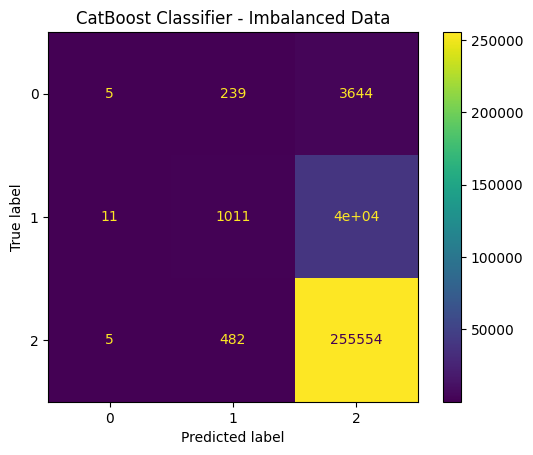


Model: LightGBM Classifier
Accuracy: 0.8527, Precision: 0.8192, Recall: 0.8527, F1: 0.7883
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.00      0.01      3888
           1       0.66      0.02      0.04     40901
           2       0.85      1.00      0.92    256041

    accuracy                           0.85    300830
   macro avg       0.60      0.34      0.32    300830
weighted avg       0.82      0.85      0.79    300830



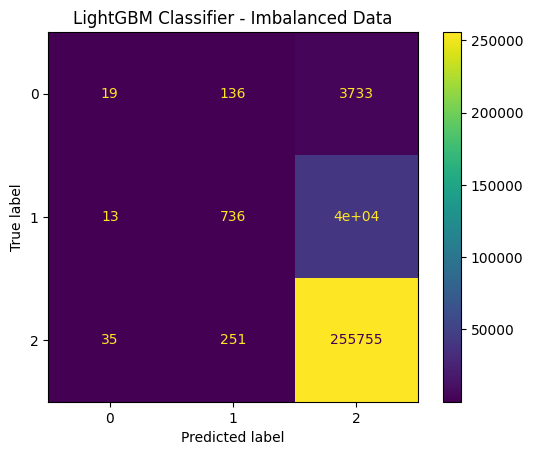


=== Balanced Data ===

Model: Random Forest
Accuracy: 0.9468, Precision: 0.9486, Recall: 0.9468, F1: 0.9466
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    256041
           1       0.96      0.88      0.92    256041
           2       0.89      0.97      0.93    256041

    accuracy                           0.95    768123
   macro avg       0.95      0.95      0.95    768123
weighted avg       0.95      0.95      0.95    768123



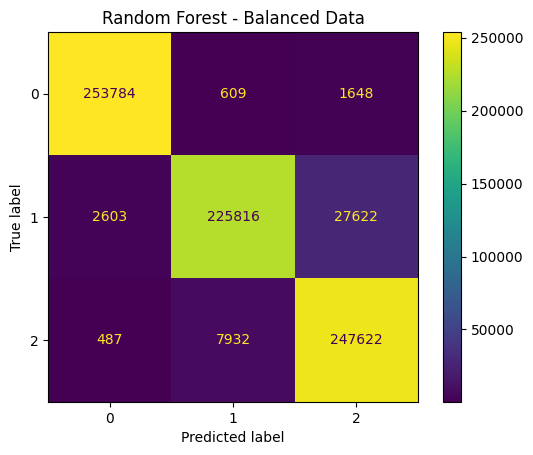


Model: Gradient Boosting
Accuracy: 0.7009, Precision: 0.6923, Recall: 0.7009, F1: 0.6882
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.73      0.70    256041
           1       0.65      0.46      0.53    256041
           2       0.76      0.92      0.83    256041

    accuracy                           0.70    768123
   macro avg       0.69      0.70      0.69    768123
weighted avg       0.69      0.70      0.69    768123



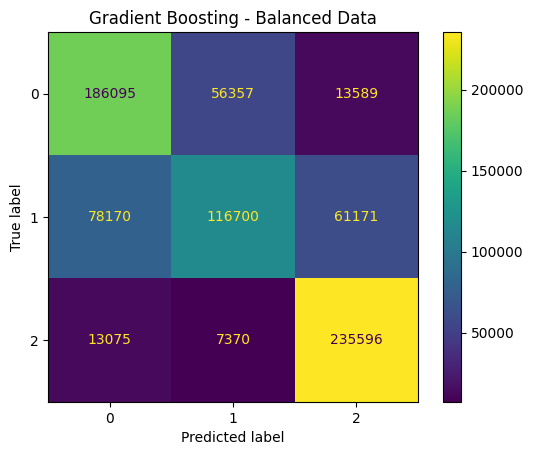


Model: K-Nearest Neighbors
Accuracy: 0.8565, Precision: 0.8825, Recall: 0.8565, F1: 0.8480
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97    256041
           1       0.74      0.98      0.84    256041
           2       0.97      0.59      0.74    256041

    accuracy                           0.86    768123
   macro avg       0.88      0.86      0.85    768123
weighted avg       0.88      0.86      0.85    768123



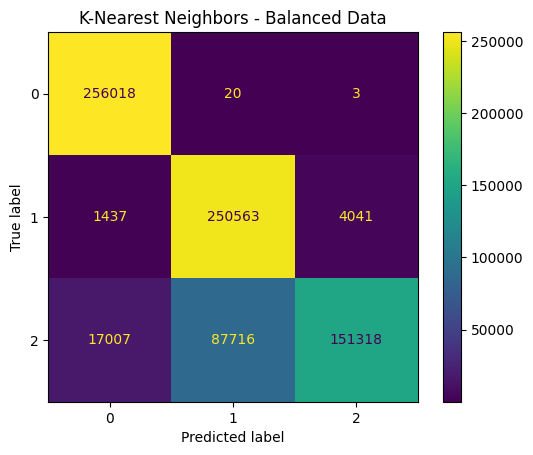


Model: XGB Classifier
Accuracy: 0.7888, Precision: 0.7874, Recall: 0.7888, F1: 0.7780
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80    256041
           1       0.79      0.55      0.65    256041
           2       0.81      0.99      0.89    256041

    accuracy                           0.79    768123
   macro avg       0.79      0.79      0.78    768123
weighted avg       0.79      0.79      0.78    768123



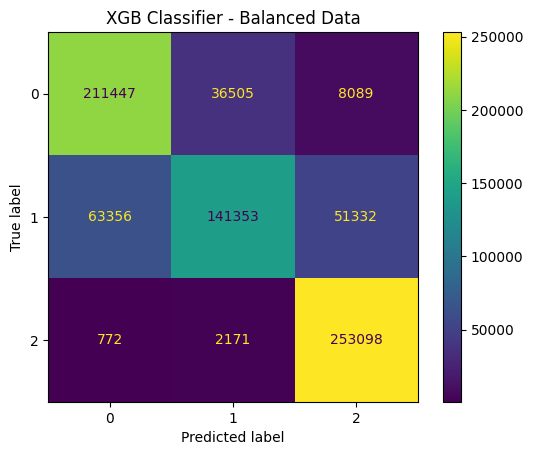


Model: CatBoost Classifier
Accuracy: 0.8067, Precision: 0.8054, Recall: 0.8067, F1: 0.7976
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81    256041
           1       0.80      0.59      0.68    256041
           2       0.83      0.99      0.90    256041

    accuracy                           0.81    768123
   macro avg       0.81      0.81      0.80    768123
weighted avg       0.81      0.81      0.80    768123



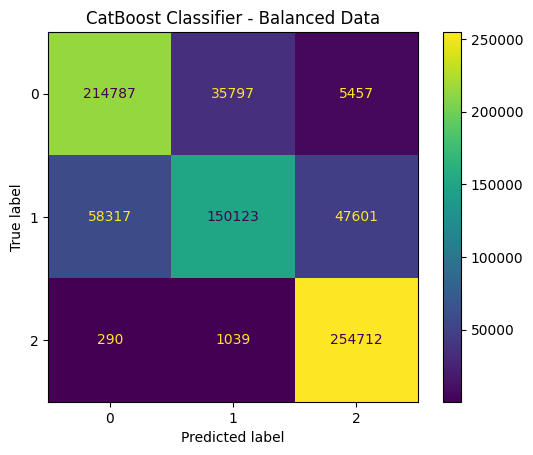


Model: LightGBM Classifier
Accuracy: 0.7747, Precision: 0.7711, Recall: 0.7747, F1: 0.7623
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.81      0.78    256041
           1       0.76      0.52      0.62    256041
           2       0.81      0.99      0.89    256041

    accuracy                           0.77    768123
   macro avg       0.77      0.77      0.76    768123
weighted avg       0.77      0.77      0.76    768123



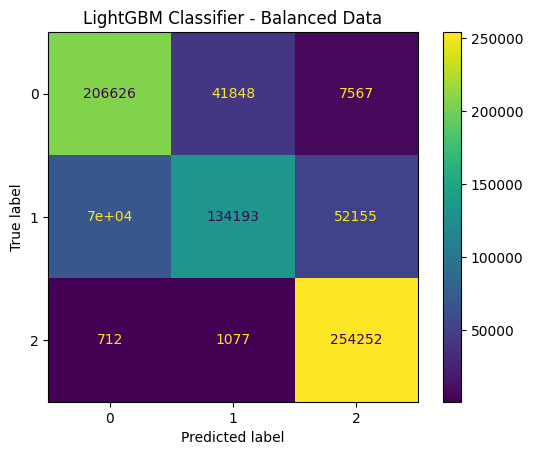

In [24]:
# ------------------------------
# Step 7: Display Results
# ------------------------------
def print_results(results, title):
    print(f"\n=== {title} ===")
    for name, metrics in results.items():
        print(f"\nModel: {name}")
        print(f"Accuracy: {metrics['Accuracy']:.4f}, Precision: {metrics['Precision']:.4f}, Recall: {metrics['Recall']:.4f}, F1: {metrics['F1']:.4f}")
        print("Classification Report:\n", metrics['Report'])
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(metrics['Confusion_Matrix'])
        disp.plot()
        plt.title(f"{name} - {title}")
        plt.show()

print_results(results_imbalanced, "Imbalanced Data")
print_results(results_balanced, "Balanced Data")
